<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">
# Dask DataFrame
We saw that multiple numpy arrays are grouped together to form a Dask array. Similar to a Dask array, a Dask dataframe consists of multiple smaller pandas dataframes. A large pandas dataframe splits row-wise to form multiple smaller dataframes. These smaller dataframes are present on a disk of a single machine, or multiple machines (thus allowing to store datasets of size larger than the memory). Each computation on a Dask dataframe parallelizes operations on the existing pandas dataframes.

### Design
Dask DataFrames coordinate many Pandas DataFrames/Series arranged along the index. A Dask DataFrame is partitioned row-wise, grouping rows by index value for efficiency. These Pandas objects may live on disk or on other machines.

<img src="images/dask-df.png">

# DataFrames: Read and Write Data
     
Dask Dataframes can read and store data in many of the same formats as Pandas dataframes.  In this example we read and write data with the popular CSV and Parquet formats, and discuss best practices when using these formats.

## Start Dask Client for Dashboard

Starting the Dask Client is optional.  It will provide a dashboard which 
is useful to gain insight on the computation.  

The link to the dashboard will become visible when you create the client below.  We recommend having it open on one side of your screen while using your notebook on the other side.  This can take some effort to arrange your windows, but seeing them both at the same is very useful when learning.

In [10]:
from dask.distributed import Client, progress
client = Client(n_workers=1, threads_per_worker=4, processes=False, memory_limit='2GB')
client

Client Scheduler: inproc://192.168.20.30/10568/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


#### Reading a csv file (comparing the read time with pandas)

In [1]:
#reading the file using pandas
import pandas as pd
%time temp = pd.read_csv("train.csv") 

Wall time: 5.35 s


In [2]:
#reading the file using dask
import dask.dataframe as dd
%time df = dd.read_csv("train.csv")

Wall time: 355 ms


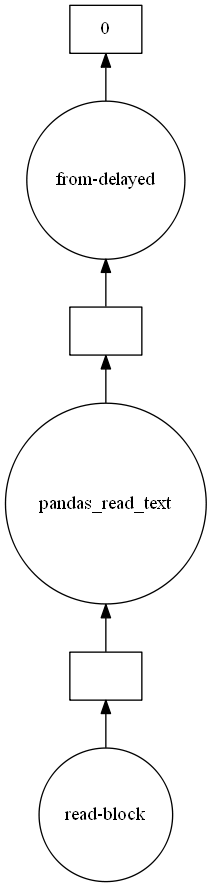

In [3]:
df.visualize()

The Black Friday dataset used here has 5,50,068 rows. On using Dask, the read time reduced more than ten times as compared to using pandas!

## Create artificial dataset

First we create an artificial dataset and write it to many CSV files.

You don't need to understand this section, we're just creating a dataset for the rest of the notebook.

In [7]:
from dask.diagnostics import ProgressBar
import dask
df = dask.datasets.timeseries()
df

,id,name,x,y
npartitions=30,,,,
2000-01-01,int32,object,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


In [29]:
import os
import datetime

if not os.path.exists('data'):
    os.mkdir('data')

def name(i):
    """ Provide date for filename given index
    
    Examples
    --------
    >>> name(0)
    '2000-01-01'
    >>> name(10)
    '2000-01-11'
    """
    return str(datetime.date(2000, 1, 1) + i * datetime.timedelta(days=1))
    
df.to_csv('data/*.csv', name_function=name);

## Read CSV files

We now have many CSV files in our data directory, one for each day in the month of January 2000.  Each CSV file holds timeseries data for that day.  We can read all of them as one logical dataframe using the `dd.read_csv` function with a glob string.

We can read one file with `pandas.read_csv` or many files with `dask.dataframe.read_csv`

In [5]:
import pandas as pd

%time df = pd.read_csv('data/2000-01-01.csv')
df.head()

Wall time: 538 ms


,timestamp,id,name,x,y
0,2000-01-01 00:00:00,991,Kevin,-0.467960,-0.059702
1,2000-01-01 00:00:01,963,Yvonne,-0.376214,-0.384586
2,2000-01-01 00:00:02,986,Edith,-0.086614,-0.111423
3,2000-01-01 00:00:03,969,Wendy,0.780283,-0.094773
4,2000-01-01 00:00:04,1063,Zelda,0.443904,0.812283


In [8]:
import dask.dataframe as dd

%time df = dd.read_csv('data/2000-*-*.csv')
df.head()

Wall time: 115 ms


,timestamp,id,name,x,y
0,2000-01-01 00:00:00,991,Kevin,-0.467960,-0.059702
1,2000-01-01 00:00:01,963,Yvonne,-0.376214,-0.384586
2,2000-01-01 00:00:02,986,Edith,-0.086614,-0.111423
3,2000-01-01 00:00:03,969,Wendy,0.780283,-0.094773
4,2000-01-01 00:00:04,1063,Zelda,0.443904,0.812283


## Do a simple computation

Whenever we operate on our dataframe we read through all of our CSV data so that we don't fill up RAM.  This is very efficient for memory use, but reading through all of the CSV files every time can be slow.

In [8]:
#%time df.groupby('name').x.mean().compute()
with ProgressBar():
    out = df.groupby('name').x.mean().compute()


[########################################] | 100% Completed |  1.5s


In [9]:
print(out)

name
Alice       0.002915
Bob         0.000649
Charlie     0.001698
Dan        -0.001703
Edith       0.000067
Frank      -0.000432
George     -0.002243
Hannah     -0.002847
Ingrid      0.001088
Jerry       0.001049
Kevin       0.002362
Laura      -0.000874
Michael     0.000221
Norbert     0.001893
Oliver      0.001801
Patricia    0.000969
Quinn      -0.001852
Ray        -0.002449
Sarah      -0.000982
Tim        -0.000333
Ursula     -0.002540
Victor      0.002099
Wendy      -0.003033
Xavier      0.001346
Yvonne     -0.002404
Zelda       0.001875
Name: x, dtype: float64


#### Write to Parquet

Instead, we'll store our data in Parquet, a format that is more efficient for computers to read and write.

In [37]:

df.to_parquet('data/2000-01.parquet', engine='pyarrow')

In [ ]:
ls data/2000-01.parquet/

## Read from Parquet

In [ ]:
df = dd.read_parquet('data/2000-01.parquet', engine='pyarrow')
df

In [40]:
with ProgressBar():
    out = df.groupby('name').x.mean().compute()


Wall time: 9.64 s
[########################################] | 100% Completed |  8.4s


## Select only the columns that you plan to use

Parquet is a column-store, which means that it can efficiently pull out only a few columns from your dataset.  This is good because it helps to avoid unnecessary data loading.

In [ ]:
%%time
df = dd.read_parquet('data/2000-01.parquet', columns=['name', 'x'], engine='pyarrow')
with ProgressBar():
    out =df.groupby('name').x.mean().compute()

## Common Uses and Anti-Uses
Dask DataFrame is used in situations where Pandas is commonly needed, usually when Pandas fails due to data size or computation speed:

Manipulating large datasets, even when those datasets don’t fit in memory
Accelerating long computations by using many cores
Distributed computing on large datasets with standard Pandas operations like groupby, join, and time series computations
#### Dask DataFrame may not be the best choice in the following situations:

- If your dataset fits comfortably into RAM on your laptop, then you may be better off just using Pandas. There may be simpler ways to improve performance than through parallelism
- If your dataset doesn’t fit neatly into the Pandas tabular model, then you might find more use in dask.bag or dask.array
- If you need functions that are not implemented in Dask DataFrame, then you might want to look at dask.delayed which offers more flexibility
- If you need a proper database with all that databases offer you might prefer something like Postgres

Here the difference is not that large, but with larger datasets this can save a great deal of time.